# Robot Ensemble Prediction: Kaggle CareerCon 2019

Credits to jesucristo on Kaggle for their wonderful public kernel (https://www.kaggle.com/jesucristo/1-smart-robots-complete-notebook-0-73) that was instrumental in me learning the ropes; various bits of exploration graphing and the general format of the notebook are greatly inspired by the work there.

In this notebook, I will be using an Ensemble method prediction after creating derivative features such as normalized parameters, Euler angles, and dot and cross products then balancing the surface classes using SMOTE.

## Setup

#### Initialize libraries and outside packages

In [1]:
# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Sci-kit learn libraries
import sklearn as sk
from sklearn import ensemble
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Imbalanced-learn libraries
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

#### Load in helper functions, these are quite lengthy!

In [2]:
# Helper functions, used much later on

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    # Retrieved from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def quaternion_to_euler(x, y, z, w):
    # Retrieved from https://stackoverflow.com/questions/53033620/how-to-convert-euler-angles-to-quaternions-and-get-the-same-euler-angles-back-fr?rq=1
    # Returns a radian measurement for roll, pitch, and yaw
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

def normalize(data):
    # Normalizes the direction-dependent parameters for an input dataset 'data'
    # Specifically, creates unit vectors for orientation, velocity, and acceleration
    data['mod_quat'] = (data['orientation_X']**2 + data['orientation_Y']**2 + data['orientation_Z']**2 + data['orientation_W']**2)**.5
    data['norm_orientation_X'] = data['orientation_X']/data['mod_quat']
    data['norm_orientation_Y'] = data['orientation_Y']/data['mod_quat']
    data['norm_orientation_Z'] = data['orientation_Z']/data['mod_quat']
    data['norm_orientation_W'] = data['orientation_W']/data['mod_quat']
    
    data['mod_angular_velocity'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 + data['angular_velocity_Z']**2)**.5
    data['norm_velocity_X'] = data['angular_velocity_X']/data['mod_angular_velocity']
    data['norm_velocity_Y'] = data['angular_velocity_Y']/data['mod_angular_velocity']
    data['norm_velocity_Z'] = data['angular_velocity_Z']/data['mod_angular_velocity']
    
    data['mod_linear_acceleration'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 + data['linear_acceleration_Z']**2)**.5
    data['norm_acceleration_X'] = data['linear_acceleration_X']/data['mod_linear_acceleration']
    data['norm_acceleration_Y'] = data['linear_acceleration_Y']/data['mod_linear_acceleration']
    data['norm_acceleration_Z'] = data['linear_acceleration_Z']/data['mod_linear_acceleration']
    return data

def add_euler_angles(data):
    # Derives Euler angles from the quaternion for an input dataset 'data'
    # *Requires normalized quaternion orientations first*
    x = data['norm_orientation_X'].tolist()
    y = data['norm_orientation_Y'].tolist()
    z = data['norm_orientation_Z'].tolist()
    w = data['norm_orientation_W'].tolist()
    eX, eY, eZ = [],[],[]
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        eX.append(xx)
        eY.append(yy)
        eZ.append(zz)
    data['euler_X'] = eX
    data['euler_Y'] = eY
    data['euler_Z'] = eZ
    return data

def add_direction_vectors(data):
    # Derives unit direction vectors from Euler angles in dataset 'data'
    roll = data['euler_X'].tolist()
    pitch = data['euler_Y'].tolist()
    yaw = data['euler_Z'].tolist()
    uX, uY, uZ = [],[],[]
    for i in range(len(roll)):
        xx = math.cos(yaw[i])*math.cos(pitch[i])
        yy = math.sin(yaw[i])+math.cos(pitch[i])
        zz = math.sin(pitch[i])
        uX.append(xx)
        uY.append(yy)
        uZ.append(zz)
    data['orientation_vector_X'] = uX
    data['orientation_vector_Y'] = uY
    data['orientation_vector_Z'] = uZ
    return data

def eng_data(data):
    # Creates engineered features within dataset 'data'
    # Intended for use on the raw X data
    
    # Idea 1: Ratios
    data['ratio_velocity-acceleration'] = data['mod_angular_velocity'] / data['mod_linear_acceleration']
    
    # Idea 2: 
    
    return data

def descriptive_features(features, data, stats):
    # Creates descriptive statistics such as max, min, std. dev, mean, median, etc. from
    # features 'stats' in dataset 'data' and stores these in 'features'
    for col in data.columns:
        if col not in stats:
            continue
        # Base statistics
        colData = data.groupby(['series_id'])[col]
        features[col + '_min'] = colData.min()
        features[col + '_max'] = colData.max()
        features[col + '_std'] = colData.std()
        features[col + '_mean'] = colData.mean()
        features[col + '_median'] = colData.median()
        
        # Derivative statistics
        features[col + '_range'] = features[col + '_max']-features[col + '_min']
        features[col + '_maxOverMin'] = features[col + '_max']/features[col + '_min']
        features[col + '_mean_abs_chg'] = colData.apply(lambda x: 
                                                        np.mean(np.abs(np.diff(x))))
        features[col + '_abs_max'] = colData.apply(lambda x: 
                                                   np.max(np.abs(x)))
        features[col + '_abs_min'] = colData.apply(lambda x: 
                                                   np.min(np.abs(x)))
        features[col + '_abs_avg'] = (features[col + '_abs_min'] 
                                      + features[col + '_abs_max'])/2
    return features

def eng_features(features):
    # Creates engineered features within dataset 'features'
    # Intended for use on the modified X data
    
    # Idea 1: Dot and cross products of unit direction vectors
    # Note: np.dot and np.cross are very slow to perform on large sets of data,
    # minimize iterations used of them
    stat = '_mean'
    Ox = features['orientation_vector_X' + stat]
    Oy = features['orientation_vector_Y' + stat]
    Oz = features['orientation_vector_Z' + stat]
    Vx = features['norm_velocity_X' + stat]
    Vy = features['norm_velocity_Y' + stat]
    Vz = features['norm_velocity_Z' + stat]
    Ax = features['norm_acceleration_X' + stat]
    Ay = features['norm_acceleration_Y' + stat]
    Az = features['norm_acceleration_Z' + stat]
    
    oDv,oDa,vDa = [],[],[]
    oCv_x,oCv_y,oCv_z = [],[],[]
    oCa_x,oCa_y,oCa_z = [],[],[]
    vCa_x,vCa_y,vCa_z = [],[],[]
    for i in range(len(Ox)):
        oDv.append(np.dot([Ox[i],Oy[i],Oz[i]],[Vx[i],Vy[i],Vz[i]]))
        oCv = np.cross([Ox[i],Oy[i],Oz[i]],[Vx[i],Vy[i],Vz[i]])
        oCv_x.append(oCv[0])
        oCv_y.append(oCv[1])
        oCv_z.append(oCv[2])
        oDa.append(np.dot([Ox[i],Oy[i],Oz[i]],[Ax[i],Ay[i],Az[i]]))
        oCa = np.cross([Ox[i],Oy[i],Oz[i]],[Vx[i],Vy[i],Vz[i]])
        oCa_x.append(oCa[0])
        oCa_y.append(oCa[1])
        oCa_z.append(oCa[2])
        vDa.append(np.dot([Vx[i],Vy[i],Vz[i]],[Ax[i],Ay[i],Az[i]]))
        vCa = np.cross([Ox[i],Oy[i],Oz[i]],[Vx[i],Vy[i],Vz[i]])
        vCa_x.append(vCa[0])
        vCa_y.append(vCa[1])
        vCa_z.append(vCa[2])
        
    features['orientation_dot_velocity'] = oDv
    features['orientation_cross_velocity_X'] = oCv_x
    features['orientation_cross_velocity_Y'] = oCv_y
    features['orientation_cross_velocity_Z'] = oCv_z
    features['orientation_dot_acceleration'] = oDa
    features['orientation_cross_acceleration_X'] = oCa_x
    features['orientation_cross_acceleration_Y'] = oCa_y
    features['orientation_cross_acceleration_Z'] = oCa_z
    features['velocity_dot_acceleration'] = vDa
    features['velocity_cross_acceleration_X'] = vCa_x
    features['velocity_cross_acceleration_Y'] = vCa_y
    features['velocity_cross_acceleration_Z'] = vCa_y
    
    return features

## Data Exploration

Load in data and analyze its composition

In [3]:
x_test = pd.read_csv('X_test.csv')
x_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
submission = pd.read_csv('sample_submission.csv')
print('Train X: {}\nTrain Y: {}\nTest X: {}\nSubmission: {}'.format(x_train.shape,y_train.shape,x_test.shape,submission.shape))

Train X: (487680, 13)
Train Y: (3810, 3)
Test X: (488448, 13)
Submission: (3816, 2)


In [4]:
x_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [5]:
x_train.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792263,3.798800,-8.522700
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000


In [6]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [7]:
y_train.describe()

,series_id,group_id
count,3810.000000,3810.000000
mean,1904.500000,37.601312
std,1099.996591,20.982743
min,0.000000,0.000000
25%,952.250000,19.000000
50%,1904.500000,39.000000
75%,2856.750000,55.000000
max,3809.000000,72.000000


In [8]:
x_test.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439
1,0_1,0,1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273
2,0_2,0,2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990
3,0_3,0,3,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270
4,0_4,0,4,-0.025548,-0.98866,-0.14792,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100


In [9]:
x_test.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000
mean,1907.500000,63.500000,0.031996,0.120651,0.018735,0.004024,0.000401,0.013669,-0.036101,0.125433,2.906588,-9.359811
std,1101.585403,36.949327,0.671977,0.714522,0.108481,0.100957,0.114485,0.089440,0.233791,1.832639,2.094727,2.802670
min,0.000000,0.000000,-0.989720,-0.989810,-0.154680,-0.156270,-2.403300,-1.193000,-1.458200,-35.040000,-107.480000,-83.173000
25%,953.750000,31.750000,-0.648130,-0.744503,-0.112660,-0.098435,-0.037396,-0.029865,-0.089842,-0.486233,2.052100,-10.125000
50%,1907.500000,63.500000,0.132910,0.397860,0.057271,0.022654,0.001107,0.007276,-0.008911,0.112490,2.900300,-9.361700
75%,2861.250000,95.250000,0.575270,0.803600,0.124770,0.083706,0.037827,0.051112,0.057876,0.727250,3.758000,-8.582075
max,3815.000000,127.000000,0.989320,0.988940,0.154250,0.152510,3.396600,1.150700,0.960280,36.628000,55.624000,59.633000


In [10]:
submission.head()

,series_id,surface
0,0,concrete
1,1,concrete
2,2,concrete
3,3,concrete
4,4,concrete


In [11]:
submission.describe()

,series_id
count,3816.000000
mean,1907.500000
std,1101.728642
min,0.000000
25%,953.750000
50%,1907.500000
75%,2861.250000
max,3815.000000


### Visualize data composition

First, we want to determine the distribution of the surfaces and group_ids in order to alter our cross-validation methodology accordingly

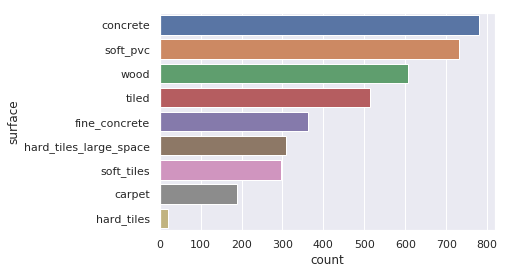

In [12]:
sns.set(style='darkgrid')
sns.countplot(y = 'surface',
              data = y_train,
              order = y_train['surface'].value_counts().index)
plt.show()

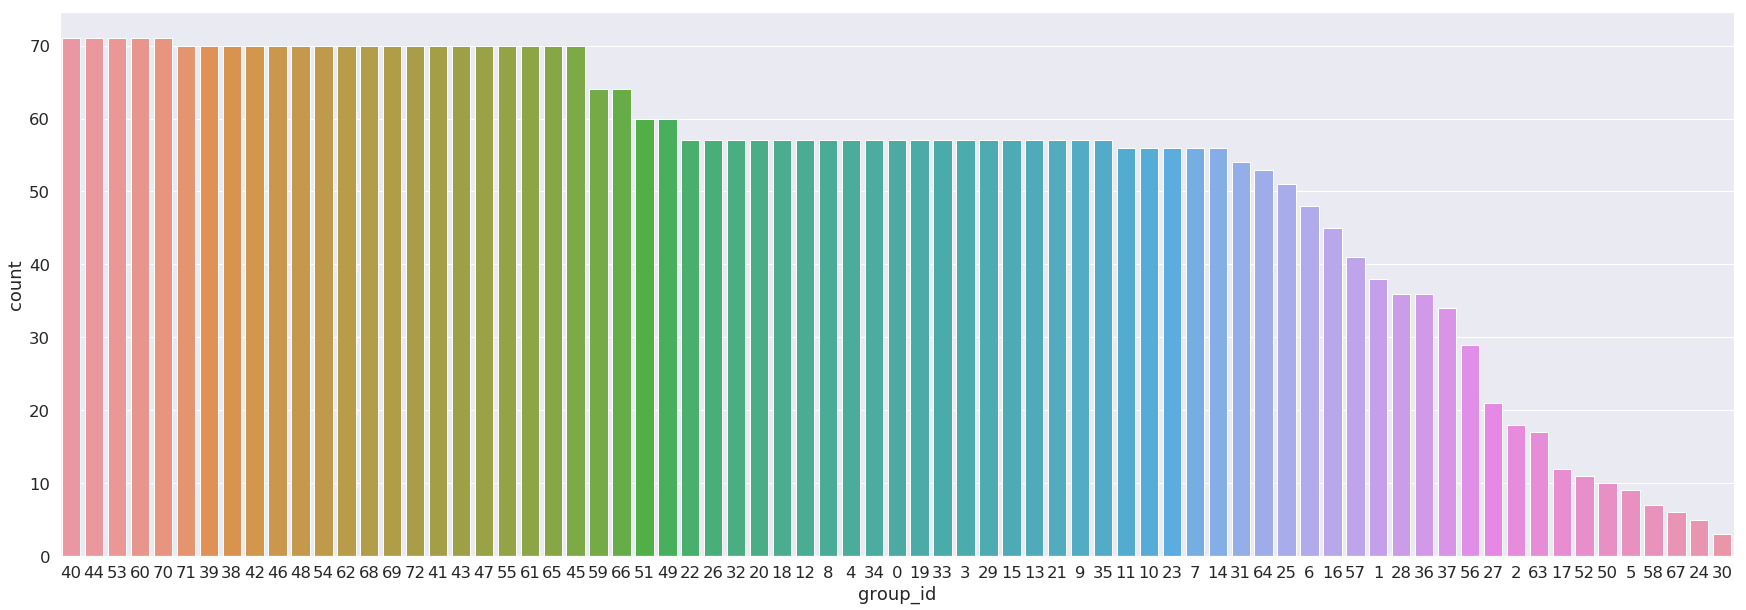

In [13]:
plt.figure(figsize=(30,10)) 
sns.set(style="darkgrid",font_scale=1.5)
sns.countplot(x="group_id", data=y_train, order = y_train['group_id'].value_counts().index)
plt.show()

Next, we want to determine feature correlation in the X train and test sets in order to drop heavily correlated variables, as these will likely overfit the model.

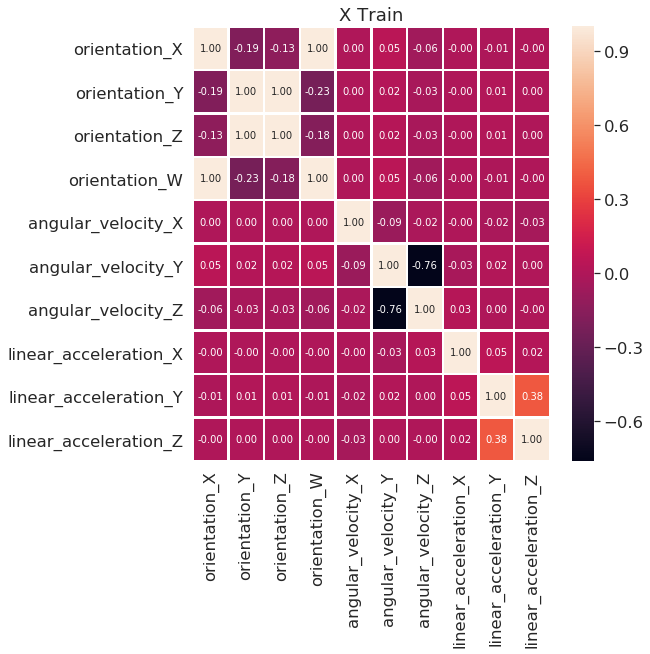

In [14]:
f,ax = plt.subplots(figsize=(8, 8))
plt.title("X Train")
sns.heatmap(x_train.iloc[:,3:].corr(), annot=True, linewidths=1.5, fmt= '.2f', annot_kws={"size": 10}, ax=ax)

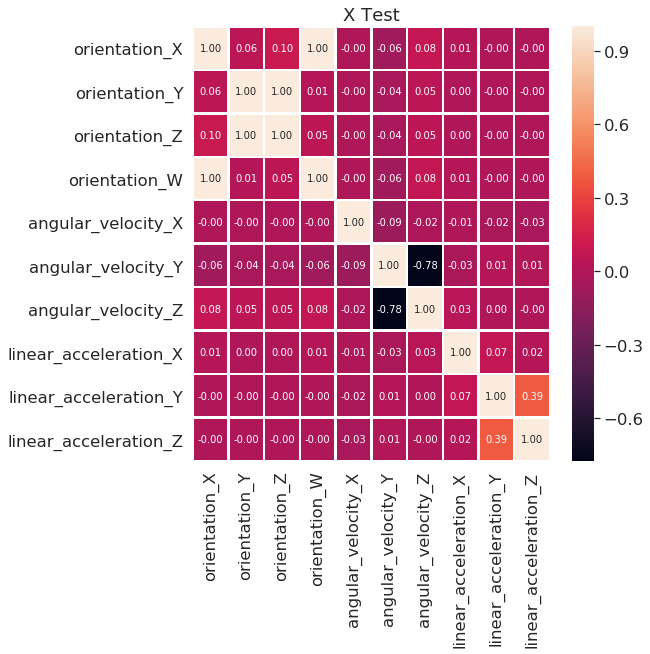

In [15]:
f,ax = plt.subplots(figsize=(8, 8))
plt.title("X Test")
sns.heatmap(x_test.iloc[:,3:].corr(), annot=True, linewidths=1.5, fmt= '.2f', annot_kws={"size": 10}, ax=ax)

From these correlation matrices, we can see that the Y and Z orientations and X and W orientations are perfectly correlated. The angular velocity and linear accelerations in directions Y and Z are each also highly correlated, dropping the features associated with one of these directions may prove beneficial later on.

### Feature Selection

Conduct feature selection on x_train and x_test data for use in model and predictions

First, we want to convert the quarternion into Euler angles and normalize the parameters (Refer to helper functions file)

In [16]:
x_train = normalize(x_train)
x_train = add_euler_angles(x_train)
x_test = normalize(x_test)
x_test = add_euler_angles(x_test)

Let's visualize the Euler angles for each set of X data:

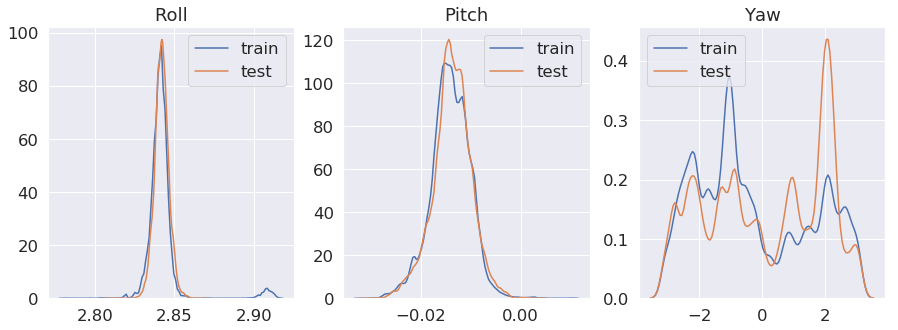

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize=(15,5))

ax1.set_title('Roll')
sns.kdeplot(x_train['euler_X'], ax=ax1, label='train')
sns.kdeplot(x_test['euler_X'], ax=ax1, label='test')

ax2.set_title('Pitch')
sns.kdeplot(x_train['euler_Y'], ax=ax2, label='train')
sns.kdeplot(x_test['euler_Y'], ax=ax2, label='test')

ax3.set_title('Yaw')
sns.kdeplot(x_train['euler_Z'], ax=ax3, label='train')
sns.kdeplot(x_test['euler_Z'], ax=ax3, label='test')

plt.show()

Now we want to create derivative features based on these existing variables and store them in the feature sets (in order to convert from the number of instances in the raw X datasets to the number of Y instances)

In [18]:
train_features = pd.DataFrame()
test_features = pd.DataFrame()

In [19]:
x_train = add_direction_vectors(x_train)
x_test = add_direction_vectors(x_test)
x_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,...,mod_linear_acceleration,norm_acceleration_X,norm_acceleration_Y,norm_acceleration_Z,euler_X,euler_Y,euler_Z,orientation_vector_X,orientation_vector_Y,orientation_vector_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,...,10.005392,-0.074817,0.210187,-0.974794,2.843273,-0.024668,1.396667,0.173198,1.984573,-0.024665
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,...,9.538638,0.035639,0.157926,-0.986808,2.843201,-0.024662,1.396651,0.173213,1.984571,-0.024660
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,...,8.874697,-0.029780,0.179409,-0.983324,2.843222,-0.024728,1.396677,0.173188,1.984574,-0.024726
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,...,10.164638,0.041993,0.108149,-0.993247,2.843183,-0.024769,1.396712,0.173154,1.984579,-0.024767
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,...,10.556132,-0.048284,0.139151,-0.989093,2.843197,-0.024785,1.396698,0.173167,1.984576,-0.024782


In [20]:
stats = ['norm_orientation_X', 'norm_orientation_Y', 'norm_orientation_Z', 
         'norm_orientation_W',
         'norm_velocity_X', 'norm_velocity_Y', 'norm_velocity_Z', 
         'norm_acceleration_X', 'norm_acceleration_Y', 'norm_acceleration_Z',
         'mod_linear_acceleration',
         'ratio_velocity-acceleration', 
         'orientation_vector_X', 'orientation_vector_Y', 'orientation_vector_Z']
train_features = descriptive_features(train_features, x_train, stats)
test_features = descriptive_features(test_features, x_test, stats)

After generating these descriptive features, we want to begin engineering custom parameters. So far, I've added dot and cross products of the mean direction vector values. While using the mean vector values will run into all sorts of arithmetic issues (namely not generating a unit vector), it would the most representative of the simple statistical measures I've used.

In [21]:
train_features = eng_features(train_features)
test_features = eng_features(test_features)
print("Train features: ", train_features.shape)
print("Test features: ", test_features.shape)

Train features:  (3810, 166)
Test features:  (3816, 166)


In [22]:
train_features.head()

,norm_orientation_X_min,norm_orientation_X_max,norm_orientation_X_std,norm_orientation_X_mean,norm_orientation_X_median,norm_orientation_X_range,norm_orientation_X_maxOverMin,norm_orientation_X_mean_abs_chg,norm_orientation_X_abs_max,norm_orientation_X_abs_min,...,orientation_cross_velocity_Y,orientation_cross_velocity_Z,orientation_dot_acceleration,orientation_cross_acceleration_X,orientation_cross_acceleration_Y,orientation_cross_acceleration_Z,velocity_dot_acceleration,velocity_cross_acceleration_X,velocity_cross_acceleration_Y,velocity_cross_acceleration_Z
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.759527,-0.758219,0.000363,-0.758666,-0.758531,0.001308,0.998278,0.000016,0.759527,0.758219,...,-0.026935,0.065787,0.627431,0.316986,-0.026935,0.065787,-0.163656,0.316986,-0.026935,-0.026935
1,-0.958960,-0.958368,0.000151,-0.958606,-0.958593,0.000592,0.999383,0.000024,0.958960,0.958368,...,-0.012240,-0.059237,0.172830,0.006623,-0.012240,-0.059237,-0.025400,0.006623,-0.012240,-0.012240
2,-0.514337,-0.509443,0.001377,-0.512057,-0.512036,0.004895,0.990483,0.000041,0.514337,0.509443,...,0.187333,0.138754,0.552523,0.754961,0.187333,0.138754,-0.406204,0.754961,0.187333,0.187333
3,-0.939682,-0.938839,0.000227,-0.939169,-0.939167,0.000843,0.999103,0.000026,0.939682,0.938839,...,-0.049884,-0.033618,0.129381,0.024552,-0.049884,-0.033618,-0.058011,0.024552,-0.049884,-0.049884
4,-0.896891,-0.886729,0.002955,-0.891301,-0.890940,0.010162,0.988670,0.000080,0.896891,0.886729,...,0.558484,0.171738,0.070354,-0.193869,0.558484,0.171738,0.931693,-0.193869,0.558484,0.558484


In [23]:
test_features.head()

,norm_orientation_X_min,norm_orientation_X_max,norm_orientation_X_std,norm_orientation_X_mean,norm_orientation_X_median,norm_orientation_X_range,norm_orientation_X_maxOverMin,norm_orientation_X_mean_abs_chg,norm_orientation_X_abs_max,norm_orientation_X_abs_min,...,orientation_cross_velocity_Y,orientation_cross_velocity_Z,orientation_dot_acceleration,orientation_cross_acceleration_X,orientation_cross_acceleration_Y,orientation_cross_acceleration_Z,velocity_dot_acceleration,velocity_cross_acceleration_X,velocity_cross_acceleration_Y,velocity_cross_acceleration_Z
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.026418,-0.025156,0.000284,-0.025810,-0.025748,0.001262,0.952224,0.000055,0.026418,0.025156,...,-0.035960,-0.025781,0.321966,-0.037452,-0.035960,-0.025781,0.040893,-0.037452,-0.035960,-0.035960
1,-0.933725,-0.931483,0.000564,-0.932288,-0.932112,0.002242,0.997599,0.000021,0.933725,0.931483,...,0.336646,0.122437,0.121979,-0.158964,0.336646,0.122437,0.453715,-0.158964,0.336646,0.336646
2,-0.231410,-0.227130,0.001054,-0.230186,-0.230600,0.004280,0.981503,0.000093,0.231410,0.227130,...,-0.105740,-0.044645,0.161472,-0.063961,-0.105740,-0.044645,0.123163,-0.063961,-0.105740,-0.105740
3,0.163320,0.167500,0.001182,0.164661,0.164260,0.004180,1.025591,0.000037,0.167500,0.163320,...,0.522585,0.022476,0.397925,0.733115,0.522585,0.022476,-0.565462,0.733115,0.522585,0.522585
4,-0.269381,-0.236371,0.009763,-0.253600,-0.253900,0.033011,0.877458,0.000260,0.269381,0.236371,...,-0.819468,-0.284236,0.146218,-0.470994,-0.819468,-0.284236,0.991610,-0.470994,-0.819468,-0.819468


The results suggest that the new features were constructed as intended, we now want to narrow down the most highly correlated features to simplify the model. We will examine the correlations on the training feature set and apply any changes to both sets of features

In [24]:
#https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
corr_matrix = train_features.corr().abs()
raw_corr = train_features.corr()

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
top_corr = pd.DataFrame(sol).reset_index()
top_corr.columns = ["var1", "var2", "abs corr"]
# with .abs() we lost the sign, and it's very important.
for x in range(len(top_corr)):
    var1 = top_corr.iloc[x]["var1"]
    var2 = top_corr.iloc[x]["var2"]
    corr = raw_corr[var1][var2]
    top_corr.at[x, "raw corr"] = corr

In [25]:
top_corr.head(15)

,var1,var2,abs corr,raw corr
0,velocity_cross_acceleration_Y,velocity_cross_acceleration_Z,1.0,1.0
1,orientation_cross_acceleration_Y,velocity_cross_acceleration_Y,1.0,1.0
2,orientation_cross_velocity_X,orientation_cross_acceleration_X,1.0,1.0
3,orientation_cross_velocity_X,velocity_cross_acceleration_X,1.0,1.0
4,orientation_cross_velocity_Y,orientation_cross_acceleration_Y,1.0,1.0
5,orientation_cross_velocity_Y,velocity_cross_acceleration_Y,1.0,1.0
6,orientation_cross_velocity_Y,velocity_cross_acceleration_Z,1.0,1.0
7,mod_linear_acceleration_max,mod_linear_acceleration_abs_max,1.0,1.0
8,mod_linear_acceleration_min,mod_linear_acceleration_abs_min,1.0,1.0
9,orientation_cross_acceleration_X,velocity_cross_acceleration_X,1.0,1.0


In [26]:
top_corr.tail(15)

,var1,var2,abs corr,raw corr
13680,norm_orientation_W_std,velocity_cross_acceleration_Z,1.199825e-04,1.199825e-04
13681,norm_orientation_W_std,orientation_cross_acceleration_Y,1.199825e-04,1.199825e-04
13682,norm_orientation_W_std,orientation_cross_velocity_Y,1.199825e-04,1.199825e-04
13683,norm_orientation_W_std,velocity_cross_acceleration_Y,1.199825e-04,1.199825e-04
13684,norm_orientation_W_maxOverMin,orientation_vector_Y_maxOverMin,9.470181e-05,9.470181e-05
13685,norm_orientation_Y_maxOverMin,norm_acceleration_Z_abs_avg,8.341409e-05,-8.341409e-05
13686,norm_velocity_Y_maxOverMin,orientation_vector_X_maxOverMin,7.382074e-05,-7.382074e-05
13687,norm_acceleration_Y_mean,orientation_vector_Z_max,5.819122e-05,5.819122e-05
13688,norm_orientation_Y_maxOverMin,mod_linear_acceleration_mean,5.798945e-05,5.798945e-05
13689,norm_orientation_Z_range,orientation_vector_Z_abs_avg,4.068132e-05,4.068132e-05


Possible drops to reduce model complexity will be made here, although I experienced better performance :

In [27]:
drops = []
# Takes the most correlated features out above a given threshold
threshold = .90
for i in range(len(top_corr)):
    if top_corr.iloc[i]["raw corr"] > threshold:
        if top_corr.iloc[i]["var1"] not in drops and top_corr.iloc[i]["var2"] not in drops:
            drops.append(top_corr.iloc[i]["var2"])
train_features = train_features.drop(columns=drops)
test_features = test_features.drop(columns=drops)

### Class Balancing

We saw that the surface classes were very heavily imbalanced, and so to solve this I will use SMOTE (Synthetic Minority Over-sampling Technique) to balance them by creating resampled training sets, to be used in the final fitting. I still will retain the original data to run a separate cross-validation on and to easily switch to if desired.

The sampling strategy I intended is to set all classes to be of the same quantity as the majority class, alter "sampling_strategy" parameter if you wish to change this

In [28]:
seed = 1920348
sm = SMOTE(sampling_strategy='not majority', random_state=seed, k_neighbors=10)
y_train_rs = pd.DataFrame()
train_features_rs, y_train_rs['surface'] = sm.fit_resample(train_features, y_train['surface'])

Chart of the data to confirm that the resampling worked as intended:

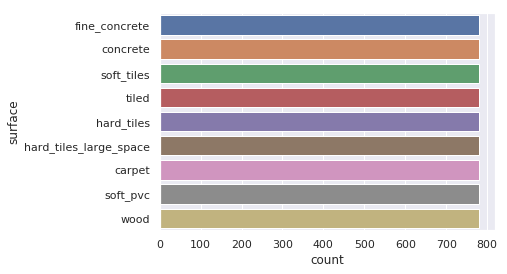

In [29]:
sns.set(style='darkgrid')
sns.countplot(y = 'surface',
              data = y_train_rs,
              order = y_train_rs['surface'].value_counts().index)
plt.show()

In [30]:
train_features.head()

,norm_orientation_X_min,norm_orientation_X_std,norm_orientation_X_maxOverMin,norm_orientation_X_abs_max,norm_orientation_Y_min,norm_orientation_Y_std,norm_orientation_Y_maxOverMin,norm_orientation_Y_abs_max,norm_orientation_Z_std,norm_orientation_Z_maxOverMin,...,orientation_vector_Z_min,orientation_vector_Z_max,orientation_vector_Z_std,orientation_vector_Z_maxOverMin,orientation_vector_Z_abs_max,orientation_vector_Z_abs_min,orientation_dot_velocity,orientation_cross_velocity_X,orientation_cross_velocity_Y,orientation_cross_velocity_Z
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.759527,0.000363,0.998278,0.759527,-0.634560,0.000471,0.997632,0.634560,0.000432,0.985582,...,-0.025792,-0.023560,0.000503,0.913453,0.025792,0.023560,-0.092728,0.316986,-0.026935,0.065787
1,-0.958960,0.000151,0.999383,0.958960,0.240740,0.000499,1.008142,0.242700,0.000508,1.060226,...,-0.012072,-0.009109,0.000822,0.754549,0.012072,0.009109,0.005539,0.006623,-0.012240,-0.059237
2,-0.514337,0.001377,0.990483,0.514337,-0.847794,0.000785,0.996581,0.847794,0.000541,0.986338,...,-0.012733,-0.011795,0.000173,0.926275,0.012733,0.011795,-0.179226,0.754961,0.187333,0.138754
3,-0.939682,0.000227,0.999103,0.939682,0.309429,0.000453,1.006595,0.311469,0.000449,1.049496,...,-0.015697,-0.014644,0.000234,0.932949,0.015697,0.014644,0.018938,0.024552,-0.049884,-0.033618
4,-0.896891,0.002955,0.988670,0.896891,0.416460,0.006165,1.050279,0.437400,0.000985,1.060499,...,-0.010192,-0.009357,0.000241,0.918150,0.010192,0.009357,0.106902,-0.193869,0.558484,0.171738


In [31]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [32]:
test_features.head()

,norm_orientation_X_min,norm_orientation_X_std,norm_orientation_X_maxOverMin,norm_orientation_X_abs_max,norm_orientation_Y_min,norm_orientation_Y_std,norm_orientation_Y_maxOverMin,norm_orientation_Y_abs_max,norm_orientation_Z_std,norm_orientation_Z_maxOverMin,...,orientation_vector_Z_min,orientation_vector_Z_max,orientation_vector_Z_std,orientation_vector_Z_maxOverMin,orientation_vector_Z_abs_max,orientation_vector_Z_abs_min,orientation_dot_velocity,orientation_cross_velocity_X,orientation_cross_velocity_Y,orientation_cross_velocity_Z
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.026418,0.000284,0.952224,0.026418,-0.988729,0.000039,0.999805,0.988729,0.000253,0.991665,...,-0.014712,-0.012998,0.000423,0.883534,0.014712,0.012998,0.025307,-0.037452,-0.035960,-0.025781
1,-0.933725,0.000564,0.997599,0.933725,0.326612,0.001654,1.017321,0.332269,0.000326,1.041858,...,-0.012780,-0.011658,0.000302,0.912182,0.012780,0.011658,0.095656,-0.158964,0.336646,0.122437
2,-0.231410,0.001054,0.981503,0.231410,0.961091,0.000260,1.001121,0.962168,0.000335,1.010802,...,-0.016117,-0.013516,0.000561,0.838642,0.016117,0.013516,0.040887,-0.063961,-0.105740,-0.044645
3,0.163320,0.001182,1.025591,0.167500,0.974850,0.000182,1.000680,0.975512,0.000182,1.004596,...,-0.013240,-0.012301,0.000293,0.929100,0.013240,0.012301,-0.252677,0.733115,0.522585,0.022476
4,-0.269381,0.009763,0.877458,0.269381,0.951504,0.002578,1.009121,0.960182,0.000562,1.013751,...,-0.012413,-0.011769,0.000173,0.948064,0.012413,0.011769,0.144258,-0.470994,-0.819468,-0.284236


## Classification

Here I run the ensemble on both versions of training data, with a boosting classifier currently in use due to overfitting issues

#### Cross-validation results for original data:

In [33]:
# create the sub models
estimators = []
model1 = ensemble.RandomForestClassifier(n_estimators=25)
estimators.append(('random-forest', model1))
#model2 = ensemble.BaggingClassifier(n_estimators=25)
#estimators.append(('bagging', model2))
#model3 = ensemble.ExtraTreesClassifier(n_estimators=25)
#estimators.append(('extra-trees', model3))

# create the ensemble model
seed = 983107135
kfold = model_selection.StratifiedKFold(n_splits=10, random_state=seed)
model = ensemble.VotingClassifier(estimators)
results = model_selection.cross_val_score(model, train_features, 
                    y_train['surface'], cv=kfold)
for i in range(len(results)):
    print("Fold", i+1, "score: ", results[i])
print("Cross-validation score average on original data: ", results.mean())

Fold 1 score:  0.8155844155844156
Fold 2 score:  0.8385416666666666
Fold 3 score:  0.7676240208877284
Fold 4 score:  0.8821989528795812
Fold 5 score:  0.8818897637795275
Fold 6 score:  0.8582677165354331
Fold 7 score:  0.8582677165354331
Fold 8 score:  0.9023746701846965
Fold 9 score:  0.8941798941798942
Fold 10 score:  0.8882978723404256
Cross-validation score average on original data:  0.8587226689573801


#### Cross-validation results for resampled data:

In [34]:
# create the ensemble model
seed = 15728651895
kfold = model_selection.StratifiedKFold(n_splits=10, random_state=seed)
model_rs = ensemble.VotingClassifier(estimators)
results = model_selection.cross_val_score(model_rs, train_features, 
                    y_train['surface'], cv=kfold)
for i in range(len(results)):
    print("Fold ", i+1, "score: ", results[i])
print("Cross-validation score average on resampled data: ", results.mean())

Fold  1 score:  0.8025974025974026
Fold  2 score:  0.84375
Fold  3 score:  0.7728459530026109
Fold  4 score:  0.8743455497382199
Fold  5 score:  0.863517060367454
Fold  6 score:  0.847769028871391
Fold  7 score:  0.8740157480314961
Fold  8 score:  0.8522427440633246
Fold  9 score:  0.8650793650793651
Fold  10 score:  0.8617021276595744
Cross-validation score average on resampled data:  0.845786497941084


The following code allows you to toggle between the original and resampled versions of the data, simply change "resample" to True or False as desired. In hindsight, resampling doesn't appear to do much good as currently set up, so I default to False for now.

In [35]:
resample = False
if resample:
    x, y = train_features_rs, y_train_rs['surface']
    final_model = model_rs
else:
    x, y = train_features, y_train['surface']
    final_model = model
final_model.fit(x, y)

VotingClassifier(estimators=[('random-forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [36]:
sk.metrics.confusion_matrix(y,final_model.predict(x), y.unique())

array([[363,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 779,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 297,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 514,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 732,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 308,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 189,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  20,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0, 607]])

My confusion matrix currently suggests overfitting, likely due to too many features. (NOTE: a near-perfect matrix is typical when oversampling)

Now we will create the final submission on the test data, first ensuring that the file is formatted as expected

In [37]:
submission['surface'] = final_model.predict(test_features)
submission.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,tiled
3,3,soft_tiles
4,4,soft_tiles


In [38]:
print("Final submission file has dimensions: ", submission.shape)

Final submission file has dimensions:  (3816, 2)


It is important to set "index = False" when creating the file, else you will wind up with an unwanted header column.

In [39]:
submission.to_csv('final_submission_7.csv', index = False)

#### The end! Let me know if you have any comments or suggestions about the solution